<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/utomoreza/assessment-mini-project/blob/main/notebook/usecase-image.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/utomoreza/assessment-mini-project/blob/main/notebook/usecase-image.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/utomoreza/assessment-mini-project/main/notebook/usecase-image.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Metadata
The dataset used is CIFAR-10. You can read its explanation in this [webpage](https://www.kaggle.com/c/cifar-10/data).

The label classes in the dataset are:
<ol start="0">
    <li>airplane</li>
    <li>automobile</li>
    <li>bird</li>
    <li>cat</li>
    <li>deer</li>
    <li>dog</li>
    <li>frog</li>
    <li>horse</li>
    <li>ship</li>
    <li>truck</li>
</ol>

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import datasets, models, layers
import keras
from keras.preprocessing import image
from keras.datasets import cifar10

In [26]:
# Adding TF Cifar10 Data ..
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [27]:
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.4, shuffle = True
)

In [5]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(6000, 32, 32, 3) (6000, 1)
(4000, 32, 32, 3) (4000, 1)


In [6]:
code_to_label = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [7]:
num_classes = len(code_to_label)

In [8]:
def show_image(idx, X, y, mapper):
    plt.imshow(X[idx])
    label = y[idx][0]
    print("Label:", mapper[label])

In [ ]:
show_image(42, X_train, y_train, code_to_label)

# Data Preprocessing

In [28]:
# Normalize the data.
def normalize(X):
    X = X.astype('float32')
    X /= 255.0
    return X

X_train = normalize(X_train)
X_val = normalize(X_val.astype)
X_test = normalize(X_test.astype)

In [29]:
# on-hot encoded to 10 classes
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Modelling

In [10]:
from keras.callbacks import EarlyStopping
from keras.layers import (
    Dense, Conv2D,  MaxPool2D,
    Flatten, GlobalAveragePooling2D,
    BatchNormalization, Layer, Add
)
from keras.models import Model, Sequential
from keras.optimizers import SGD
import tensorflow as tf

## Training

In [11]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [12]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [13]:
def ResNet34(shape=(32, 32, 3), classes=10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet34")
    return model

In [30]:
model = ResNet34()

In [31]:
model.compile(
    optimizer="adam", loss='categorical_crossentropy',
    metrics=["categorical_accuracy",
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score()]
)

In [16]:
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 38, 38, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 19, 19, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 19, 19, 64)           256       ['conv2d[0][0]']       

In [22]:
BATCH_SIZE = 64
EPOCHS = 50

In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4523473300666286012
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12137389417850038851
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [32]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

In [33]:
history = model.fit(
    X_train, y_train, batch_size=BATCH_SIZE,
    epochs=EPOCHS, shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)

Epoch 1/50
782/782 [==============================] - 68s 63ms/step - loss: 1.5529 - categorical_accuracy: 0.4306 - precision_2: 0.6370 - recall_2: 0.2352 - f1_score: 0.4263 - val_loss: 1.6050 - val_categorical_accuracy: 0.4578 - val_precision_2: 0.5628 - val_recall_2: 0.3510 - val_f1_score: 0.4474
Epoch 2/50
782/782 [==============================] - 44s 56ms/step - loss: 1.1280 - categorical_accuracy: 0.5978 - precision_2: 0.7400 - recall_2: 0.4538 - f1_score: 0.5956 - val_loss: 1.3325 - val_categorical_accuracy: 0.5397 - val_precision_2: 0.6717 - val_recall_2: 0.4177 - val_f1_score: 0.5218
Epoch 3/50
782/782 [==============================] - 45s 57ms/step - loss: 0.9304 - categorical_accuracy: 0.6722 - precision_2: 0.7814 - recall_2: 0.5676 - f1_score: 0.6711 - val_loss: 1.3859 - val_categorical_accuracy: 0.5433 - val_precision_2: 0.6443 - val_recall_2: 0.4353 - val_f1_score: 0.5448
Epoch 4/50
782/782 [==============================] - 38s 49ms/step - loss: 0.8032 - categorical_acc

## Evaluating

In [40]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(1, 2,figsize=(12, 5))
    # summarize history for accuracy
    axs[0].plot(history.history['categorical_accuracy'])
    axs[0].plot(history.history['val_categorical_accuracy'])
    axs[0].set_title('Model Categorical Accuracy')
    axs[0].set_ylabel('Categorical Accuracy')
    axs[0].set_xlabel('Epoch')

    axs[0].legend(['train', 'validate'], loc='upper left')

    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')

    # # summarize history for precision
    # axs[1][0].plot(history.history['precision'])
    # axs[1][0].plot(history.history['val_precision'])
    # axs[1][0].set_title('Model Precision')
    # axs[1][0].set_ylabel('Precision')
    # axs[1][0].set_xlabel('Epoch')
    # axs[1][0].legend(['train', 'validate'], loc='upper left')

    # # summarize history for recall
    # axs[1][1].plot(history.history['recall'])
    # axs[1][1].plot(history.history['val_recall'])
    # axs[1][1].set_title('Model Recall')
    # axs[1][1].set_ylabel('Recall')
    # axs[1][1].set_xlabel('Epoch')
    # axs[1][1].legend(['train', 'validate'], loc='upper left')

#     # summarize history for f1-score
#     axs[2][0].plot(history.history['f1_score'])
#     axs[2][0].plot(history.history['val_f1_score'])
#     axs[2][0].set_title('Model F1 Score')
#     axs[2][0].set_ylabel('F1 Score')
#     axs[2][0].set_xlabel('Epoch')
#     axs[2][0].legend(['train', 'validate'], loc='upper left')

    fig.tight_layout()
    plt.show()

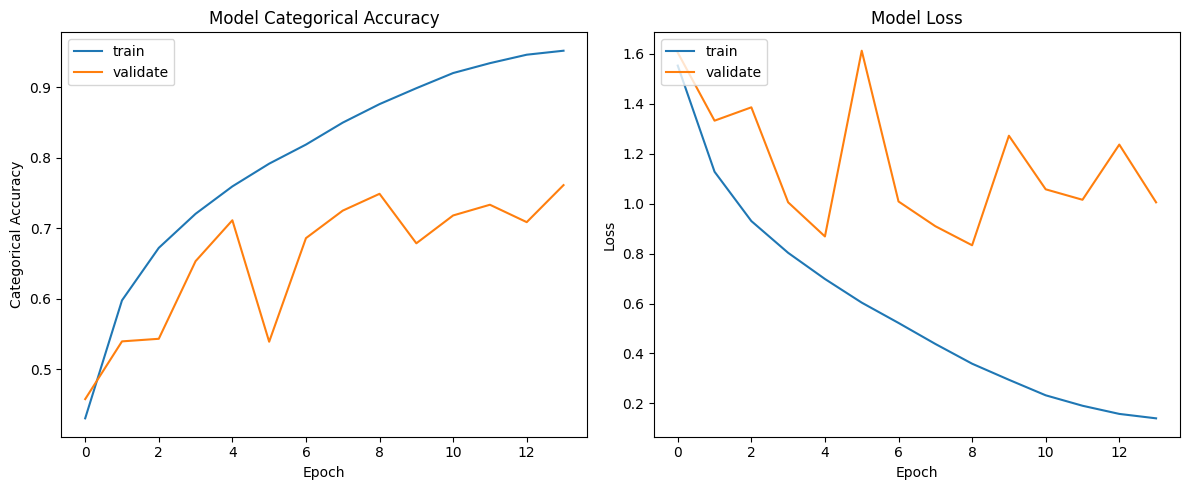

In [41]:
# list all data in history
plotmodelhistory(history)

In [47]:
test_loss, test_acc, test_prec, test_rec, test_f1score = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_loss)
print("Test Precision:", test_loss)
print("Test Recall:", test_loss)
for idx, score in enumerate(test_f1score):
    print(f"Test F1-Score for label {idx}-{code_to_label[idx]}:", score)

125/125 [==============================] - 2s 13ms/step - loss: 0.8259 - categorical_accuracy: 0.7500 - precision_2: 0.7899 - recall_2: 0.7218 - f1_score: 0.7480
Test Loss: 0.8259403705596924
Test Accuracy: 0.8259403705596924
Test Precision: 0.8259403705596924
Test Recall: 0.8259403705596924
Test F1-Score for label 0-airplane: 0.80597013
Test F1-Score for label 1-automobile: 0.87096775
Test F1-Score for label 2-bird: 0.68903226
Test F1-Score for label 3-cat: 0.51028806
Test F1-Score for label 4-deer: 0.6625
Test F1-Score for label 5-dog: 0.66459626
Test F1-Score for label 6-frog: 0.7777778
Test F1-Score for label 7-horse: 0.8172589
Test F1-Score for label 8-ship: 0.8449198
Test F1-Score for label 9-truck: 0.83678156


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred)


# Prediction

In [82]:
def predict_from_file(img_path, model, target_size):
    # preprocess
    img = image.load_img(img_path, target_size=target_size)
    example = image.img_to_array(img)
    example = np.expand_dims(example, axis=0)
    example = normalize(example)

    # predict
    pred = model.predict(example)
    y_pred = np.argmax(pred)
    confidence = np.max(pred)
    pred_label = code_to_label[y_pred]

    return y_pred, pred_label, confidence

In [ ]:
img_path = "./sample/kodok.jpg"

In [ ]:
predict_from_file(img_path, model, X_train.shape[1:])

1/1 [==============================] - 0s 23ms/step


(6, 'frog', 0.63908195)

In [52]:
!wget -O /content/kodok.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR3s4EWxQtMS557iW24-EQrz6lj5scDEXTEdiOAsnxQ5A&s

/bin/bash: line 1: s: command not found
--2024-05-05 04:59:09--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR3s4EWxQtMS557iW24-EQrz6lj5scDEXTEdiOAsnxQ5A
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 142.250.125.113, 142.250.125.139, 142.250.125.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|142.250.125.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9241 (9.0K) [image/jpeg]
Saving to: ‘/content/kodok.jpg’

/content/kodok.jpg  100%[===================>]   9.02K  --.-KB/s    in 0s      

2024-05-05 04:59:09 (105 MB/s) - ‘/content/kodok.jpg’ saved [9241/9241]

